# Persistence Images

We will develop a Python implementation of the persistence images as detailed in https://arxiv.org/pdf/1507.06217.pdf

In [1]:
%load_ext autoreload
%autoreload 2

## Generate a persistence diagram with Ripser 

In [2]:
from itertools import product

import numpy as np
from sklearn import datasets
from scipy.stats import multivariate_normal as mvn

from ripser import Rips
import matplotlib.pyplot as plt

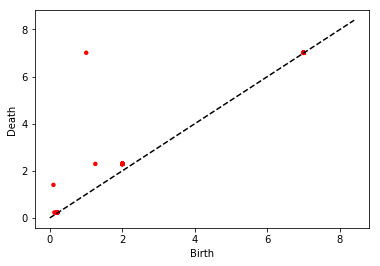

In [3]:
data = np.concatenate([datasets.make_circles(n_samples=100)[0], 
                       10 * datasets.make_circles(n_samples=100)[0]])
rips = Rips()
dgm = rips.fit_transform(data)
diagram = dgm[1]
rips.plot(diagram)

In [4]:
class PersImage:
    def __init__(self, diagram, pixels=50*50):
        self.diagram = diagram
        self.landscape = None
        self.is_landscape = False
        
        assert int(np.sqrt(pixels)) == np.sqrt(pixels), "Pixels must be a square"
        self.pixels = pixels
    
    def transform(self):
        
        assert self.landscape is not None, "Must generate a landscape first"
        
        data = self.landscape
        N = int(np.sqrt(self.pixels))
        cov = 0.2
        weighting = pim.weighting()

        # Define an NxN grid over our landscape
        maxBD = np.max(data)
        dx = maxBD / (2 * N) 
        xs = np.linspace(0, maxBD, N) + dx
        ys = np.linspace(0, maxBD, N) + dx
        grid = np.array(list(product(xs, reversed(ys))))
        
    
        # Define zeros
        img = np.zeros(len(grid))

        # weights for each data point
        weights = np.apply_along_axis(weighting, 1, data) 
        
        for i, pixel in enumerate(grid):    
            # pixel defines bottom left corner, compute w.r.t center
            smoothing = mvn.pdf(data, mean=pixel, cov=cov)
            img[i] = np.dot(smoothing, weights)

        img = img.reshape((N,N)).T
        return img
    
    def weighting(self):
        ''' Define a weighting function, 
                for stability results to hold, the function must be 0 at y=0.    
        ''' 
        
        # TODO: Implement a logistic function
        
        maxy = np.max(self.landscape[:,1])
        
        def linear(interval):
            # linear function of y such that f(0) = 0 and f(max(y)) = N
            b, d = interval[0], interval[1]
            assert d >= 0, "Should not be defined for values below y=0"
            return len(self.landscape[:,1]) / maxy * d
            
        return linear
    
    def kernel(self, kernel_type="gaussian"):
        """ This will return whatever kind of kernal we want to use.
            Must have signature (ndarray size NxM, ndarray size 1xM) -> ndarray size Nx1
        """
        
        def gaussian(data, pixel):
            cov = 0.2
            return mvn.pdf(data, mean=pixel, cov=cov)
        
        return gaussian
    
    def to_landscape(self, diagram=None):
        """ Convert a diagram to a landscape
            (b,d) -> (b, d-b)
        """
        
        if diagram is None:
            diagram = np.copy(self.diagram)
        
        if self.is_landscape is False:
            diagram[:,1] -= diagram[:,0]
            self.is_landscape = True
            self.landscape = diagram
            
        return diagram
    
    def show(self, img):
        """ Visualize the persistence image
        """
        maxBD= np.max(self.landscape)
        plt.imshow(img, extent=(0,maxBD,0,maxBD))

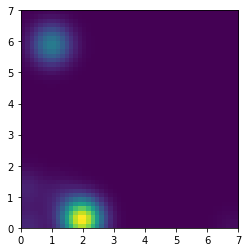

In [6]:
pim = PersImage(diagram)
_ = pim.to_landscape()
img = pim.transform()
pim.show(img)
# rips.plot(pim.landscape, diagonal=False)